Import Necessary Libraries

In [0]:
import h5py

In [0]:
import random

In [0]:
from tensorflow.keras.utils import to_categorical

In [0]:
from tensorflow.python.keras.layers import Dense, Flatten, MaxPooling2D
from tensorflow.python.keras import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.optimizers import Adadelta
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy

In [0]:
import matplotlib.pyplot as plt
import matplotlib.image as img
%matplotlib inline

In [0]:
import cv2

In [0]:
import numpy as np

In [0]:
import pandas as pd

In [0]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

Load the Dataset

In [0]:
#Load the Dataset
hf = h5py.File('trainingsetv1d0.h5', 'r')

Creating a List of all Glitch Names

In [0]:

glitch_set=[]
for glitch in hf.keys():
  glitch_set.append(glitch)

Preprocess Images to Desired Size

In [0]:

def preprocessX (data, glitch_set):

  image_count=0

  for glitch in glitch_set:
    length = len(hf[glitch][data].keys())
    image_count=image_count+length

  X=np.zeros((image_count, 94, 114))
  Y=[]
  i = 0 

  for glitch in glitch_set:
    for image in hf[glitch][data].keys():
      img_top = np.hstack((hf[glitch][data][image]['0.5.png'][0][:], hf[glitch][data][image]['1.0.png'][0][:]))
      img_bottom = np.hstack((hf[glitch][data][image]['2.0.png'][0][:], hf[glitch][data][image]['4.0.png'][0][:]))
      img = np.vstack((img_top, img_bottom))
      resized = cv2.resize(img, (114, 94), interpolation = cv2.INTER_AREA)
      X[:][:][i] = resized
      Y.append(glitch)
      i = i+1 

  #Reshape for Input to CNN
  X=X.reshape((image_count, 94, 114, 1))

  return X, Y

Preprocess Labels to Numerical Values

In [0]:

def preprocessY (lst):
  integer_encoded = label_encoder.fit_transform(np.array(lst))
  trainY=to_categorical(integer_encoded)
  return trainY

In [0]:
trainX, trainY=preprocessX('train', glitch_set)
testX, testY=preprocessX('test', glitch_set)
validationX, validationY=preprocessX('validation', glitch_set)

In [0]:
trainY=preprocessY(trainY)
testY=preprocessY(testY)
validationY=preprocessY(validationY)

In [0]:
input_shape=(94, 114, 1)
batch_size =64

Create Model

In [0]:
#Define Model
model=Sequential()
model.add(Conv2D(128, kernel_size=(5, 5), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(22, activation='softmax'))

model.compile(loss=CategoricalCrossentropy(),
              optimizer=Adam(),
              metrics=['accuracy'])


In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 90, 110, 128)      3328      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 45, 55, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 41, 51, 128)       409728    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 25, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 64000)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               16384256  
_________________________________________________________________
dense_1 (Dense)              (None, 22)                5

Fit the Model

In [0]:
def gen(features, labels, batch_size):
 # Create empty arrays to contain batch of features and labels#
 batch_features = np.zeros((batch_size, 94, 114))
 batch_labels = np.zeros((batch_size,3))
 while True:
   for i in range(batch_size):
     # choose random index in features
     index= random.choices(range(len(labels)),k=batch_size)
     batch_features = features[index]
     batch_labels = labels[index]
     batch_features = batch_features.reshape(batch_size, 94, 114, 1)
   yield batch_features, batch_labels

In [0]:
history=model.fit_generator(gen(trainX, trainY, batch_size), 
                    steps_per_epoch=trainY.shape[0]//batch_size, 
                    epochs=10, 
                    validation_data=gen(validationX, validationY, batch_size),
                    validation_steps=validationY.shape[0]//batch_size
                    )

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
93/93 [==============================] - 375s 4s/step - loss: 0.6779 - accuracy: 0.8216 - val_loss: 0.2456 - val_accuracy: 0.9203
Epoch 2/10
93/93 [==============================] - 373s 4s/step - loss: 0.1766 - accuracy: 0.9556 - val_loss: 0.1973 - val_accuracy: 0.9539
Epoch 3/10
93/93 [==============================] - 372s 4s/step - loss: 0.1080 - accuracy: 0.9751 - val_loss: 0.1575 - val_accuracy: 0.9609
Epoch 4/10
93/93 [==============================] - 369s 4s/step - loss: 0.0676 - accuracy: 0.9822 - val_loss: 0.1323 - val_accuracy: 0.9742
Epoch 5/10
93/93 [==============================] - 373s 4s/step - loss: 0.0443 - accuracy: 0.9882 - val_loss: 0.2004 - val_accuracy: 0.9625
Epoch 6/10
93/93 [==============================] - 373s 4s/step - loss: 0.0448 - accuracy: 0.9889 - val_loss: 0.1535 - val_accuracy: 0.9555
Epoch 7/10
93/93 [==============================] - 376s 4s/step - loss: 0.030

In [0]:
his=history

Training and Validation Accuracy


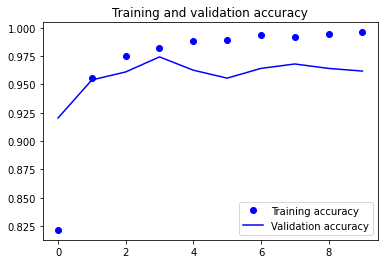

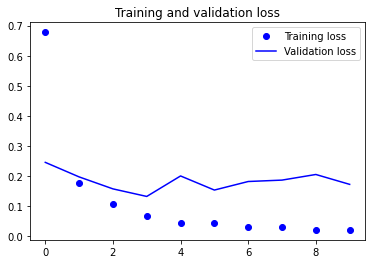

In [0]:
accuracy = his.history['accuracy']
val_accuracy = his.history['val_accuracy']
loss = his.history['loss']
val_loss = his.history['val_loss']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Test Accuracy

In [0]:
score = model.evaluate(testX, testY, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.14665627479553223
Test accuracy: 0.9728049635887146


Prediction

In [0]:
prediction=model.predict(testX)

In [0]:
pred_labels = np.argmax(prediction, axis=-1)    

In [0]:
test_labels= np.argmax(testY, axis=-1)  

Precision and Recall

In [0]:
from sklearn.metrics import classification_report

In [0]:
#Precision/Recall
print(classification_report(test_labels, pred_labels, target_names=glitch_set))

                     precision    recall  f1-score   support

          1080Lines       1.00      1.00      1.00        49
        1400Ripples       1.00      1.00      1.00        35
     Air_Compressor       1.00      0.89      0.94         9
               Blip       0.99      0.99      0.99       280
              Chirp       1.00      1.00      1.00        10
     Extremely_Loud       1.00      0.97      0.99        68
              Helix       1.00      0.98      0.99        42
           Koi_Fish       0.99      0.95      0.97       124
   Light_Modulation       0.95      0.98      0.97        86
Low_Frequency_Burst       1.00      0.97      0.98        98
Low_Frequency_Lines       0.97      0.94      0.96        68
          No_Glitch       0.87      1.00      0.93        27
  None_of_the_Above       0.57      0.62      0.59        13
       Paired_Doves       1.00      1.00      1.00         4
         Power_Line       0.99      1.00      0.99        68
    Repeating_Blips    

Confusion Matrix

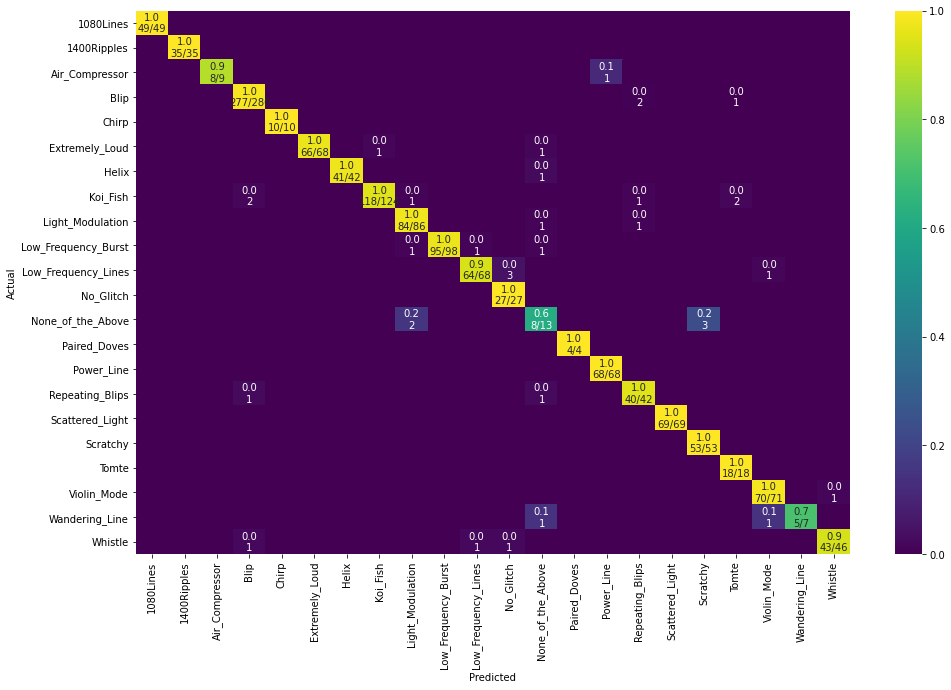

In [0]:
#Confusion Matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_cm(y_true, y_pred, label, figsize=(16,10)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) 
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f\n%d' % (p, c)
    cm = pd.DataFrame(cm_perc, index=label, columns=label)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, annot=annot, fmt='', ax=ax, cmap='viridis')
    
plot_cm(test_labels, pred_labels, glitch_set)